In [33]:
# Basics
import pickle as pkl
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Preprocessing
from scipy import stats
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

# Models
from sklearn import svm
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
import xgboost as xgb

# Misc
import sys
from IPython.display import clear_output

%run utils/utils_metrics.py
%run utils/utils_line_supercover.py

### 1. Load data

In [34]:
n_chunks = 1
chunks = [pkl.load(open('../data/bin_chunks/ttd_chunk_{0}.pkl'.format(i), 'rb')) for i in range(1, n_chunks + 1)]
dataset = pd.concat(chunks)
print("Data shape:", dataset.shape)
dataset.head()

Data shape: (48605, 10)


,pu_t,do_t,trip_dist,pu_lon,pu_lat,do_lon,do_lat,duration,vec_dist,trip_ratio
0,2016-02-16 19:56:06,2016-02-16 20:10:46,8.53,-73.995750,40.764488,-73.926292,40.867458,880,7.983998,1.068387
1,2016-02-11 10:23:41,2016-02-11 10:45:04,1.95,-73.994110,40.751068,-73.993401,40.736019,1283,1.039087,1.876648
2,2016-02-21 14:21:57,2016-02-21 14:30:07,0.50,-73.973160,40.752728,-73.982178,40.756962,490,0.556130,0.899070
3,2016-02-11 22:51:59,2016-02-11 22:57:41,1.30,-73.991280,40.744808,-73.985909,40.731178,342,0.981839,1.324045
4,2016-02-13 18:32:08,2016-02-13 18:43:51,1.50,-73.992897,40.741280,-73.975967,40.748734,703,1.026608,1.461123


### 2. Preprocessing

### 2.1 Augmenting (grid based approach)

In [ ]:
gMap = GridMap(size=(300,300), bbox = (LAT_NORTH, LAT_SOUTH, LON_EAST, LON_WEST))
gMap.fitGrid(dataset, func='median');

In [7]:
dataset['grid_estim_trip_distance'] = gMap.predictFactor(dataset) * dataset.vec_dist
dataset.head()

,pu_t,do_t,trip_dist,pu_lon,pu_lat,do_lon,do_lat,duration,vec_dist,trip_ratio,grid_estim_trip_distance
0,2016-02-16 19:56:06,2016-02-16 20:10:46,8.53,-73.995750,40.764488,-73.926292,40.867458,880,7.983998,1.068387,9.272084
1,2016-02-11 10:23:41,2016-02-11 10:45:04,1.95,-73.994110,40.751068,-73.993401,40.736019,1283,1.039087,1.876648,1.347992
2,2016-02-21 14:21:57,2016-02-21 14:30:07,0.50,-73.973160,40.752728,-73.982178,40.756962,490,0.556130,0.899070,0.718421
3,2016-02-11 22:51:59,2016-02-11 22:57:41,1.30,-73.991280,40.744808,-73.985909,40.731178,342,0.981839,1.324045,1.278448
4,2016-02-13 18:32:08,2016-02-13 18:43:51,1.50,-73.992897,40.741280,-73.975967,40.748734,703,1.026608,1.461123,1.315511


In [10]:
lat_data = np.array(pd.concat((dataset.pu_lat, dataset.do_lat))).reshape(-1,1)
lon_data = np.array(pd.concat((dataset.pu_lon, dataset.do_lon))).reshape(-1,1)
dur_data = np.array(dataset.duration.astype(float)).reshape(-1,1)

# New feature
etd_data = np.array(dataset.grid_estim_trip_distance.astype(float)).reshape(-1,1)

scaler_type = 'StandardScaler' # Other options: MinMaxScaler
lat_scaler = getattr(preprocessing, scaler_type)()
lon_scaler = getattr(preprocessing, scaler_type)()
etd_scaler = getattr(preprocessing, scaler_type)()
out_scaler = getattr(preprocessing, scaler_type)()

# Inputs
lat_scaler.fit(lat_data);
lon_scaler.fit(lon_data);
etd_scaler.fit(etd_data)

# Output
out_scaler.fit(dur_data);

X = np.hstack((lat_scaler.transform(dataset[['pu_lat','do_lat',]]),
               lon_scaler.transform(dataset[['pu_lon','do_lon',]]),
               etd_scaler.transform(etd_data)))
y = out_scaler.transform(dur_data)

#### Quick look at inputs and output

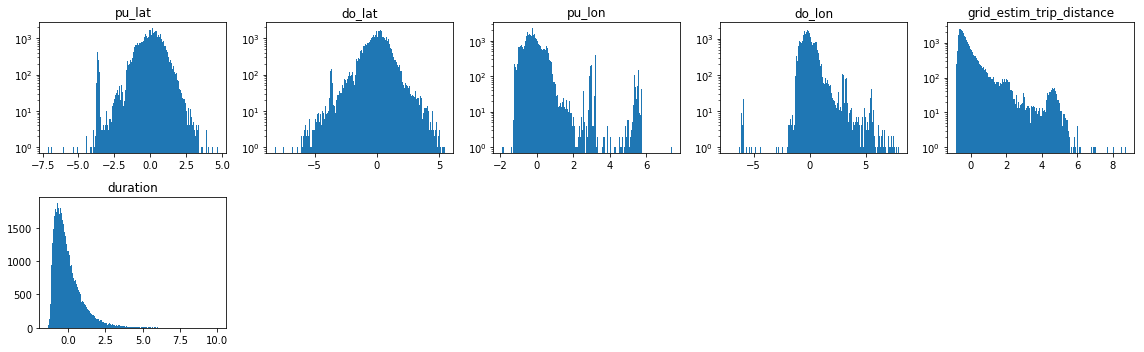

In [9]:
plt.figure(figsize=(16,5))
titles = ['pu_lat', 'do_lat', 'pu_lon', 'do_lon', 'grid_estim_trip_distance', 'duration']
for i in range(5):
    plt.subplot(2,5,i+1)
    plt.hist(X[:,i], bins='auto', log=True)
    plt.title(titles[i])
plt.subplot(2,5,6)
plt.hist(y, bins='auto')
plt.title(titles[-1])
plt.tight_layout()
plt.show()

### 3. Splitting data

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

test_size = len(y_test)
train_size = len(y_train)

y_test_denorm = out_scaler.inverse_transform(y_test)

In [31]:
# # Store splitted data
pkl.dump(X_train, open('../splitted_data/fs2/x_train.dat', 'wb'))
pkl.dump(y_train, open('../splitted_data/fs2/y_train.dat', 'wb'))
pkl.dump(X_test, open('../splitted_data/fs2/x_test.dat', 'wb'))
pkl.dump(y_test, open('../splitted_data/fs2/y_test.dat', 'wb'))

In [11]:
# Read splitted data
X_train = pkl.load(open('../splitted_data/fs2/x_train.dat', 'rb'))
y_train = pkl.load(open('../splitted_data/fs2/y_train.dat', 'rb'))
X_test = pkl.load(open('../splitted_data/fs2/x_test.dat', 'rb'))
y_test = pkl.load(open('../splitted_data/fs2/y_test.dat', 'rb'))

test_size = len(y_test)
train_size = len(y_train)

y_test_denorm = out_scaler.inverse_transform(y_test)

### 4. SVM

In [12]:
kernels = ['rbf']
C_values = [0.1, 1, 10]

#### 4.1 Training

In [37]:
for kern in kernels:
    for C in C_values:
        sys.stdout.write("\rTraining SVM with kernel {0} and C = {1}".format(kern,C))
        svm_reg = svm.SVR(kernel=kern, gamma='auto', C=C)
        svm_reg.fit(X_train, y_train.ravel())
        pkl.dump(svm_reg, open('../init_models/fs2/svms/svm_reg_{0}_{1}.mdl'.format(kern,C), 'wb'))
        sys.stdout.flush()
        clear_output()
sys.stdout.write("Done.")        

Done.

#### 4.2 Testing

In [13]:
y_pred_svm = []
for kern in kernels:
    for C in C_values:
        print("Running tests on SVM with kernel {0} and C = {1}".format(kern,C))
        svm_reg = pkl.load(open('../init_models/fs2/svms/svm_reg_{0}_{1}.mdl'.format(kern,C), 'rb'))
        y_pred_svm.append(svm_reg.predict(X_test))
        sys.stdout.flush()
        clear_output()
sys.stdout.write("Done.")        

Done.

#### Denormalize predicited data

In [14]:
y_pred_svm_denorm = out_scaler.inverse_transform(y_pred_svm)

# Set all negative outputs to zero (we're predicting time)
y_pred_svm_denorm[y_pred_svm_denorm < 0] = 0

# Transform back again
y_pred_svm = out_scaler.transform(y_pred_svm_denorm)

#### 4.3 Metrics

In [15]:
idx = pd.MultiIndex.from_tuples([(k,C) for k in kernels for C in C_values], names=['Kernel','C'])

metrics_svm = compute_metrics(y_true = y_test, y_pred = y_pred_svm, 
                              y_true_denorm = y_test_denorm, y_pred_denorm = y_pred_svm_denorm, 
                              indices = idx)  
metrics_svm

Exp. Var.        R2            MSE        RMSE      nMSE  \
Kernel C                                                                
rbf    0.1    0.688719  0.681236  107492.321465  327.860216  0.312139   
       1.0    0.700514  0.694322  103079.559112  321.060055  0.299325   
       10.0   0.703525  0.697921  101866.067804  319.164641  0.295801   

                nRMSE      MSLE     RMSLE       MAPE  
Kernel C                                              
rbf    0.1   0.558694  0.153747  0.392106  32.811355  
       1.0   0.547106  0.147407  0.383936  31.398340  
       10.0  0.543876  0.145728  0.381744  30.850910

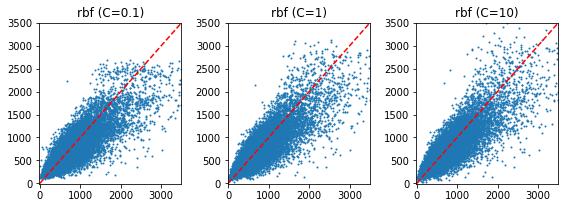

In [41]:
fig = plt.figure(figsize=(8,8))
for i,kern in enumerate(kernels):
    for j,C in enumerate(C_values):
        plt.subplot(3, 3, j + 3*i + 1)
        plt.scatter(y_test_denorm, y_pred_svm_denorm[j + 3*i], s = 1)
        plt.plot((-1,3500),(-1,3500), '--', c='r')
        plt.title('{0} (C={1})'.format(kern,C))
        plt.xlim((-10,3500))
        plt.ylim((-10,3500))
plt.tight_layout()
plt.show()

#### 4.4 Evaluate accuracy agains range of tolerance for best SVM

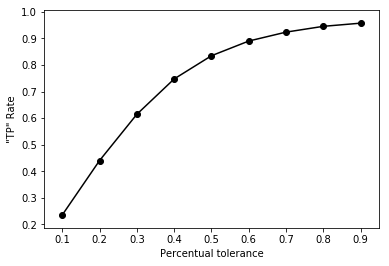

In [43]:
y_pred_svm_best = y_pred_svm_denorm[2].reshape(-1,1)

tolerance = np.arange(0.1,1,0.1)
acc = [np.sum(np.isclose(y_pred_svm_best, y_test_denorm, rtol=tol))/test_size for tol in tolerance]

plt.plot(tolerance, acc, c='k')
plt.scatter(tolerance, acc, c='k')
plt.ylabel('"TP" Rate')
plt.xlabel('Percentual tolerance')
plt.show()

### 5. Random Forests

In [16]:
forest_size = [100,200, 300]
max_feats   = [2,3,4]

#### 5.1 Training

In [45]:
for n_trees in forest_size:
    for max_feat in max_feats:
        sys.stdout.write("\rTraining forest with {0} trees using maximum of {1} features".format(n_trees, max_feat))
        rf_reg = RandomForestRegressor(n_estimators=n_trees, max_features=max_feat, n_jobs=2)
        rf_reg.fit(X_train, y_train.ravel())
        pkl.dump(rf_reg, open('../init_models/fs2/random_forests/rf_reg_{0}_{1}.mdl'.format(n_trees,max_feat), 'wb'))
        sys.stdout.flush()
clear_output()
sys.stdout.write("Done.")        

Done.

#### 5.2 Testing

In [17]:
y_pred_rf = []
for n_trees in forest_size:
    for max_feat in max_feats:
        sys.stdout.write("\rTesting forest with {0} trees using maximum of {1} features".format(n_trees, max_feat))
        rf_reg = pkl.load(open('../init_models/fs2/random_forests/rf_reg_{0}_{1}.mdl'.format(n_trees,max_feat), 'rb'))
        y_pred_rf.append(rf_reg.predict(X_test));
        sys.stdout.flush()
clear_output()
sys.stdout.write("Done.")        

Done.

#### Denormalize predicited data

In [18]:
y_pred_rf_denorm = out_scaler.inverse_transform(y_pred_rf)

# Set all negative outputs to zero (we're predicting time)
y_pred_rf_denorm[y_pred_rf_denorm < 0] = 0

# Transform back again
y_pred_rf = out_scaler.transform(y_pred_rf_denorm)

#### 4.3 Metrics

In [19]:
idx = pd.MultiIndex.from_tuples([(f,m) for f in forest_size for m in max_feats], names=['#Tress','MaxFeat'])

metrics_svm = compute_metrics(y_true = y_test, y_pred = y_pred_rf, 
                              y_true_denorm = y_test_denorm, y_pred_denorm = y_pred_rf_denorm, 
                              indices = idx)  
metrics_svm

Exp. Var.        R2            MSE        RMSE      nMSE  \
#Tress MaxFeat                                                             
100    2         0.699198  0.698882  101541.836841  318.656299  0.294860   
       3         0.694592  0.694198  103121.497767  321.125361  0.299447   
       4         0.695086  0.694663  102964.694343  320.881122  0.298991   
200    2         0.699504  0.699189  101438.374691  318.493916  0.294559   
       3         0.697273  0.696848  102227.774907  319.730785  0.296852   
       4         0.694830  0.694379  103060.502180  321.030376  0.299270   
300    2         0.701334  0.701037  100815.321836  317.514286  0.292750   
       3         0.696922  0.696485  102350.269169  319.922286  0.297207   
       4         0.695554  0.695095  102818.850317  320.653786  0.298568   

                   nRMSE      MSLE     RMSLE       MAPE  
#Tress MaxFeat                                           
100    2        0.543010  0.155149  0.393890  35.334847  
       3        0.547217  0.158291  0.397858  35.746374  
       4        0.546801  0.159014  0.398766  35.891947  
200    2        0.542733  0.154481  0.393040  35.228097  
       3        0.544841  0.156758  0.395927  35.587729  
       4        0.547055  0.158347  0.397928  35.769253  
300    2        0.541064  0.154128  0.392591  35.167756  
       3        0.545167  0.157010  0.396245  35.598287  
       4        0.546414  0.158160  0.397694  35.811774

### 6. XGBoost

In [24]:
xgb_reg = xgb.XGBRegressor(n_estimators=300, max_depth=10)
xgb_reg.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, importance_type='gain',
       learning_rate=0.1, max_delta_step=0, max_depth=10,
       min_child_weight=1, missing=None, n_estimators=300, n_jobs=1,
       nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
       subsample=1)

In [25]:
y_pred_xgb = xgb_reg.predict(X_test).reshape(1,-1)

In [26]:
y_pred_xgb_denorm = out_scaler.inverse_transform(y_pred_xgb)

# Set all negative outputs to zero (we're predicting time)
y_pred_xgb_denorm[y_pred_xgb_denorm < 0] = 0

# Transform back again
y_pred_xgb = out_scaler.transform(y_pred_xgb_denorm)

In [27]:
compute_metrics(y_true = y_test, y_pred = y_pred_xgb,
                y_true_denorm = y_test_denorm, y_pred_denorm = y_pred_xgb_denorm,
                indices=[0])

,Exp. Var.,R2,MSE,RMSE,nMSE,nRMSE,MSLE,RMSLE,MAPE
0,0.689065,0.68892,104901.106234,323.884403,0.304614,0.551919,0.158546,0.398178,35.546446


In [16]:
compute_metrics(y_true = y_test, y_pred = y_pred_xgb,
                y_true_denorm = y_test_denorm, y_pred_denorm = y_pred_xgb_denorm,
                indices=[0])

,Exp. Var.,R2,MSE,RMSE,nMSE,nRMSE,MSLE,RMSLE
0,0.689065,0.68892,104901.106234,323.884403,0.304614,0.551919,0.158546,0.398178


### 7. Neural Network

In [28]:
mlp_reg = MLPRegressor(hidden_layer_sizes=(80,40,20,10,1))

In [29]:
mlp_reg.fit(X_train, y_train.ravel())

MLPRegressor(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(80, 40, 20, 10, 1), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
       random_state=None, shuffle=True, solver='adam', tol=0.0001,
       validation_fraction=0.1, verbose=False, warm_start=False)

In [30]:
y_pred_mlp = mlp_reg.predict(X_test).reshape(1,-1)

In [31]:
y_pred_mlp_denorm = out_scaler.inverse_transform(y_pred_mlp)

# Set all negative outputs to zero (we're predicting time)
y_pred_mlp_denorm[y_pred_mlp_denorm < 0] = 0

# Transform back again
y_pred_mlp = out_scaler.transform(y_pred_mlp_denorm)

In [32]:
compute_metrics(y_true = y_test, y_pred = y_pred_mlp,
                y_true_denorm = y_test_denorm, y_pred_denorm = y_pred_mlp_denorm,
                indices=[0])

,Exp. Var.,R2,MSE,RMSE,nMSE,nRMSE,MSLE,RMSLE,MAPE
0,0.713771,0.712363,96995.761365,311.441425,0.281659,0.530715,0.14416,0.379684,30.48899


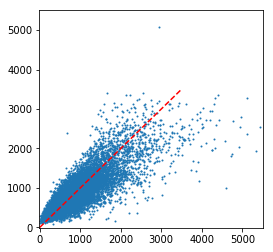

In [33]:
fig = plt.figure(figsize=(4,4))
plt.scatter(y_test_denorm, y_pred_mlp_denorm, s = 1)
plt.plot((-1,3500),(-1,3500), '--', c='r')
plt.xlim((-10,5500))
plt.ylim((-10,5500))
plt.show()